# py4DSTEM Tutorial - Differential Phase Contrast Reconstruction
---

### Introduction

This is a tutorial notebook intended to teach you how to use py4DSTEM to perform a differential phase contrast (DPC) reconstruction, and a ptychographic phase reconstruction from a 4D-STEM dataset. The steps we will perform are:

* [Part 0 - Download and load the 4D-STEM dataset.](#part_00)
* [Part 1 - Calculate the center-of-mass (CoM) for each probe position.](#part_01)
* [Part 2 - Reconstruct the differential phase contrast (DPC) signal.](#part_02)
* [Part 3 - Reconstruct the object wave using ptychography](#part_03)

A deep knowledge of the theory of DPC imaging is not required for this tutorial. All you need to know is that (given some assumptions) when a STEM probe passes through a sample potential, the STEM probe will deflect in the direction of the gradient of this potential. In a far field (diffraction space) measurement, we can directly measure the average momentum change of a STEM probe as a 2-element vector by taking the CoM of the electron counts. We repeat this process for all STEM probe positions. To reconstruct the sample's potential, we simply need to invert this 2D gradient measurement.

For more information on the history and theory of DPC, and the algorithm used in py4DSTEM, see the following references:
* N Dekkers & H De Lang, [Differential phase contrast in a STEM](http://xrm.phys.northwestern.edu/research/pdf_papers/1974/dekkers_optik_1974.pdf), Optik 41, 452–456 (1974).
* A Lubk & J Zweck. [Differential phase contrast: An integral perspective](https://doi.org/10.1103/PhysRevA.91.023805), Phys Rev A 91, 023805 (2015).
* B Savitzky et al., [py4DSTEM: A Software Package for Four-Dimensional Scanning Transmission Electron Microscopy Data Analysis](https://doi.org/10.1017/S1431927621000477), Microscopy and Microanalysis (2021).

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (clophus@lbl.gov)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Stephanie Ribet (sribet@u.northwestern.edu)
- Alex Rakowski (arakowski@lbl.gov)
- Georgios Varnavides (gvarnavides@berkeley.edu)

The 4D-STEM dataset used here is from Hao Yang, Pete Nellist, and collaborators, from this reference:
* Yang, H, Rutte, R, Jones, L, Simson, M, Sagawa, R, Ryll, H, Huth, M, Pennycook, T, Green, M, Soltau, H, Kondo, Y, Davis, BG & Nellist, PD (2016 b). [Simultaneous atomic-resolution electron ptychography and Z-contrast imaging of light and heavy elements in complex nanostructures](https://doi.org/10.1038/ncomms12532) Nature Communications  7, 12532 (2016) 

Updated 2022 Dec 21

---
# Part 0 - Download the tutorial data <a class="anchor" id="part_00"></a>

You can download the tutorial dataset here: (945 megabytes)
* [Filled Carbon Nanotube](https://drive.google.com/file/d/1bHv3u61Cr-y_GkdWHrJGh1lw2VKmt3UM/view?usp=sharing)

Once you have downloaded this data, update the variable `file_path_input` in the next cell to reflect that path to the file on your computer.

In [108]:
# Initialization - import the needed packages.
# For this tutorial, we will need py4DSTEM, numpy, and h5py
import py4DSTEM
import numpy as np
import h5py    
from scipy.ndimage import rotate

In [30]:
# Set the file paths for the input datasets.
# The location of these files may be different, depending on your operating system and browser download path.
# If you are running this tutorial on Binder, you do not need to change this path.

file_data = 'C:/data/4DSTEM/tutorial/carbon_nanotube_data.h5'
# file_data = 'data/carbon_nanotube_data.h5'

In [31]:
# py4DSTEM.io.read(file_data)

In [32]:
# This dataset is stored in an HDF5 file, but is different from the current native py4DSTEM HDF5 / h5 format.

# So, our first step is to list all of the groups inside the .h5 file: (code adapted from issue #406 on the h5py github repo)
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print('%s %s' % (key, val))
        
f = h5py.File(file_data,'r')
f.visititems(print_attrs)

4D-STEM_data
4D-STEM_data/metadata
4D-STEM_data/metadata/calibration
K_pix_size [0.6233536 0.6233536]
K_pix_units b'angstrom^-1'
R_pix_size [0.28 0.28]
R_pix_units b'angstrom'
R_to_K_rotation_degrees 8
4D-STEM_data/metadata/comments
4D-STEM_data/metadata/microscope
accelerating_voltage 80000.0
convergence_semiangle_mrad 26.029473684210526
4D-STEM_data/metadata/original
4D-STEM_data/metadata/original/all
4D-STEM_data/metadata/original/shortlist
4D-STEM_data/metadata/processing
4D-STEM_data/metadata/sample
4D-STEM_data/metadata/user
4DSTEM_experiment
4DSTEM_experiment/data
4DSTEM_experiment/data/datacubes
emd_group_type 1
4DSTEM_experiment/data/datacubes/datacube_0
4DSTEM_experiment/data/datacubes/datacube_0/datacube
4DSTEM_experiment/data/diffractionslices
4DSTEM_experiment/data/pointlistarrays
4DSTEM_experiment/data/pointlists
4DSTEM_experiment/data/realslices


In [33]:
f['4DSTEM_experiment']['data']['datacubes']['datacube_0']['datacube']

<HDF5 dataset "datacube": shape (253, 253, 44, 44), type "<f8">

There are many `groups`, `datasets`, and `attributes` inside this .h5 file. However, we require only one, named:

`4DSTEM_experiment/data/datacubes/datacube_0/datacube`

In [34]:
# The next step is to import this experiment as a py4DSTEM datacube.
# note that we are accessing a "dataset" inside various groups (groups are the HDF5 equivalent of directories)
dataset = py4DSTEM.io.datastructure.DataCube(
    data=f['4DSTEM_experiment']['data']['datacubes']['datacube_0']['datacube'][:]
)

In [35]:
dataset

DataCube( A 4-dimensional array of shape (253, 253, 44, 44) called 'datacube',
          with dimensions:

          Rx = [0,1,...] pixels
          Ry = [0,1,...] pixels
          Qx = [0,1,...] pixels
          Qy = [0,1,...] pixels
)

In [36]:
# Let's examine the mean diffraction space image - first we compute it:
dataset.get_dp_mean();

# note that we can also use this method to return the mean diffraction pattern as a numpy array, by using:
# dp_mean = dataset.get_dp_mean()

# If we don't return a numpy array, we can instead access this image by looking in the "tree" of our dataset:
# dataset.tree['dp_mean'].data

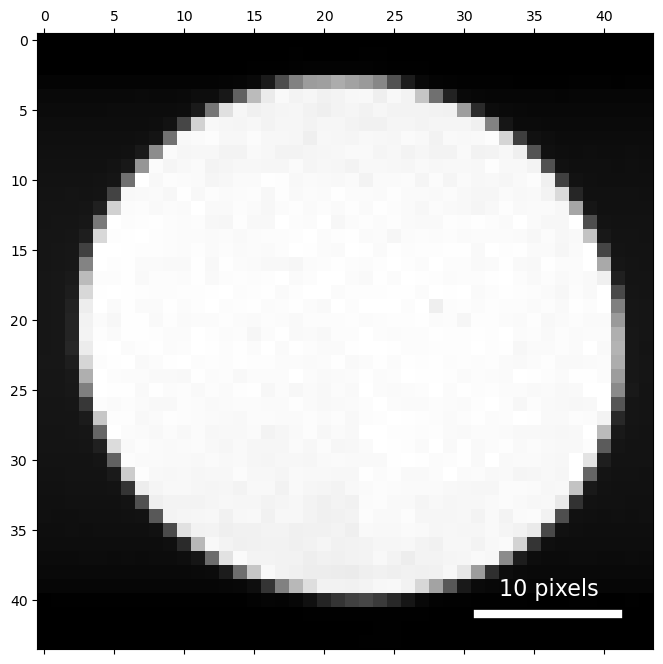

In [37]:
# Plot the mean diffraction pattern
py4DSTEM.show(
    dataset.tree['dp_mean'],
)

In the mean diffraction pattern image, we can clearly see the initial STEM probe. For a thin specimen, most of the electrons will remain inside the bright field (BF) disk, i.e. the angular range of the initial STEM beam). This means that changing the TEM camera length or cropping the dataset around the BF disk is reasonable, as is the case here.

Estimated probe radius = 18.93 pixels


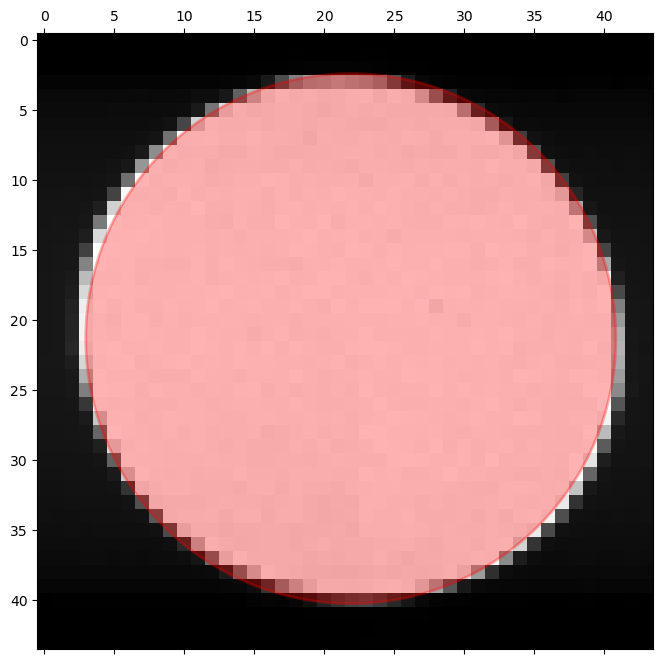

In [38]:
# Estimate the radius of the BF disk, and the center coordinates
probe_semiangle, probe_qx0, probe_qy0 = py4DSTEM.process.calibration.get_probe_size(dataset.tree['dp_mean'].data)

# plot the mean diffraction pattern, with the estimated probe radius overlaid as a circle
py4DSTEM.visualize.show_circles(
    dataset.tree['dp_mean'].data, 
    (probe_qx0, probe_qy0), 
    probe_semiangle)

# Print the estimate probe radius
print('Estimated probe radius =', '%.2f' % probe_semiangle, 'pixels')

By overlaying a circle, we can see a common artifact in STEM simulations: ellipticity of either the original probe aperture, or the projecter system of the TEM. This ellipticity will not affect our DPC measurement, although we should be careful to use a large enough virtual detector / cropping range to fully capture the BF signal for all probe positions.

In [39]:
# Next, create a bright field (BF) virtual detector using the the center beam position, and expanding the radius slightly (+ 2 px).
center = (probe_qx0, probe_qy0)
radius = probe_semiangle + 2

dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius),
    name = 'bright_field'
);

100%|█████████████████████████████████████████████████████████████████████████| 64009/64009 [00:00<00:00, 84163.20it/s]


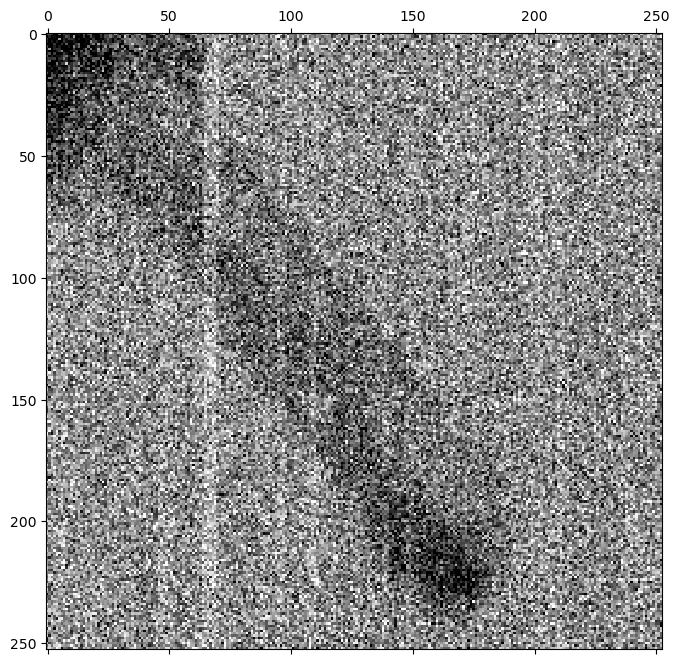

In [40]:
# Plot the bright field image:
py4DSTEM.show(dataset.tree['bright_field'].data)

Virtually no contrast is visible in the virtual BF image - this image contrast roughly corresponds to the `amplitude` of the sample's exit wave. In the following sections, we will use CoM-DPC to measure the `phase`, which will hopefully produce significantly more signal in the image.

# Part 1 - Calculate the CoM for each probe position. <a class="anchor" id="part_01"></a>

In this section, we will compute the (qx_shift, qy_shift) momentum vector estimate for all probe positions. We accomplish this by computing the first moment of the intentisty distribution in the x and y directions.

c:\users\cophus\repos\py4dstem\py4DSTEM\process\phase\iterative_base_class.py:175: UserWarning: Iterative reconstruction will not be quantitative unless you specify real-space calibrations in 'A'
  
c:\users\cophus\repos\py4dstem\py4DSTEM\process\phase\iterative_base_class.py:201: UserWarning: Iterative reconstruction will not be quantitative unless you specify appropriate reciprocal-space calibrations
  if self._energy is not None:


Best fit rotation = -12.0 degrees.
No need to transpose diffraction intensities.


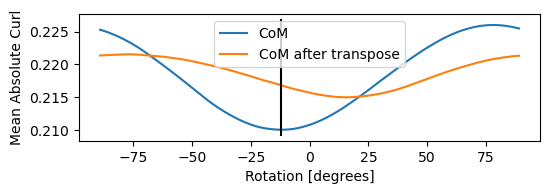

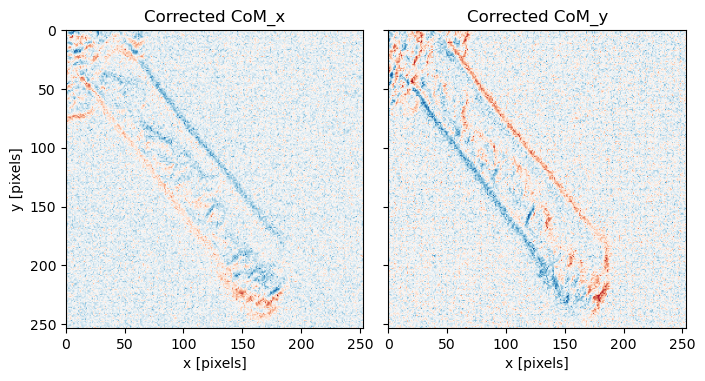

In [41]:
dpc = py4DSTEM.process.phase.DPCReconstruction(
    dataset,
    energy=80e3,
).preprocess(
)

Note that the DPC module warns you that the reconstruction will not be quantitative if we do not specify both the step size of the STEM probe, and the pixel size of the diffraction space images. By quantitative, we mean that the reconstruct phase values are properly reconstructed in radians, as opposed to a more qualitative phase image.

We also automatically estimate the rotation between real and reciprocal space, which in this case is a small -12 degrees - we can see that the corrected CoM images are nearly identical to the normalized CoM images.  This slight misalignment between the STEM scan direction and diffraction patterns will not affect a DPC reconstruction very much, but could strongly affect the ptychographic reconstruction below.

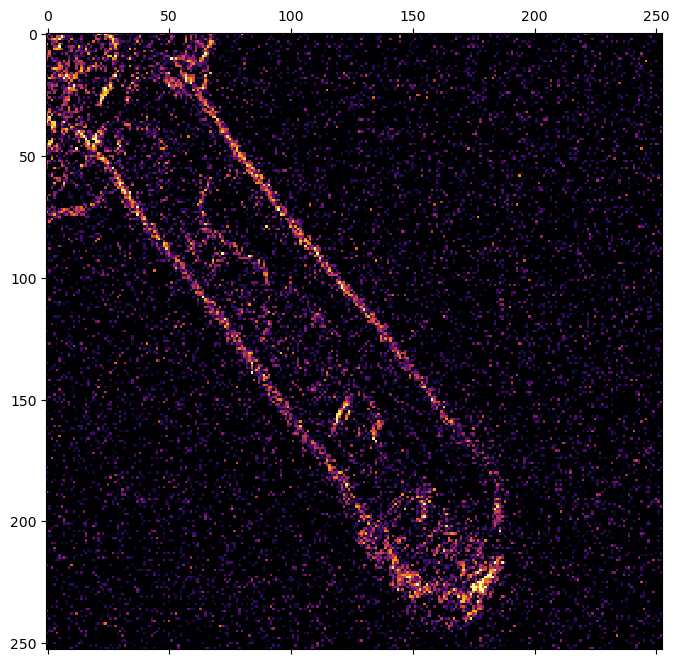

In [42]:
# Plot the electric field magnitude of the sample, from the CoM gradients.
py4DSTEM.show(
    (dpc.com_x**2 + dpc.com_y**2)**0.5,
    cmap='inferno',
    vmin=0.7,
    vmax=0.999,
)

# Part 2 - Reconstruct the phase using DPC. <a class="anchor" id="part_02"></a>

The final step is to invert the above gradient measurements into the underlying scalar field, the phase shift or potential of the sample.

### Brief description of our phase reconstruction method

The CoM DPC signal measures the gradient of the sample's potential. If we had the potential, we could differentiate it numerically to obtain this gradient. We want to go the other direction however. We could in principle write down the series of linear equations for the center-difference numerical gradient operator, and solve for all of the pixels by inverting this sparse matrix (with some assumptions at the boundaries).  However constructing this matrix is tedious, and it's fairly unstable without regularzation. 

Fortunately, there is a better way! As in most microscopy data analysis problems, we will use Fourier transforms. Essentially, we will compute the "inverse gradient" to reconstruct the DPC phase signal.  For more information, see:
B Savitzky et al., [py4DSTEM: A Software Package for Four-Dimensional Scanning Transmission Electron Microscopy Data Analysis](https://doi.org/10.1017/S1431927621000477), Microscopy and Microanalysis (2021).

In [43]:
dpc.reconstruct(
    max_iter=32
);

Reconstructing phase:  69%|███████████████████████████████████████▏                 | 22/32 [00:01<00:00, 19.70 iter/s]c:\users\cophus\repos\py4dstem\py4DSTEM\process\phase\iterative_dpc.py:384: UserWarning: Step-size has decreased below stopping criterion 1e-06.
  warnings.warn(
Reconstructing phase:  75%|██████████████████████████████████████████▊              | 24/32 [00:01<00:00, 19.56 iter/s]


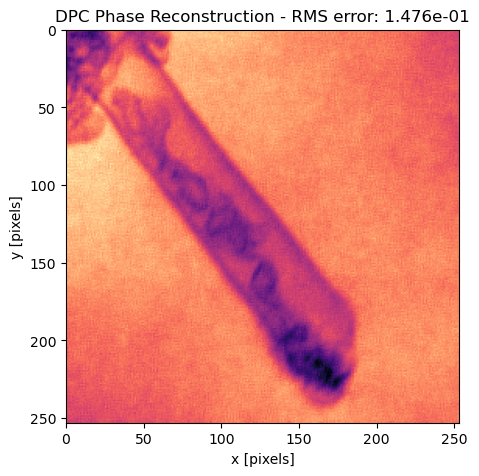

In [44]:
dpc.visualize(
    figsize=(6,6),
);

Note that the phase signal is flipped - the nanotube phase is lower than the surrounding vacuum. Because our sample consists of positive ionic cores screened by negative electron orbitals, the sample's electroscatic potential should always be >=0, and therefore the object wave's phase shift should also be positive.

This is an unphysical artifact, which is caused by rotating the diffraction patterns by 180 degrees. Our direction-finding routine above cannot solve for this 180 degree rotation ambiguity - instead it is up to the user to fix it! We can apply this 180 flip in the preprocessing step: 

c:\users\cophus\repos\py4dstem\py4DSTEM\process\phase\iterative_base_class.py:175: UserWarning: Iterative reconstruction will not be quantitative unless you specify real-space calibrations in 'A'
  
c:\users\cophus\repos\py4dstem\py4DSTEM\process\phase\iterative_base_class.py:201: UserWarning: Iterative reconstruction will not be quantitative unless you specify appropriate reciprocal-space calibrations
  if self._energy is not None:
c:\users\cophus\repos\py4dstem\py4DSTEM\process\phase\iterative_base_class.py:388: UserWarning: Best fit rotation forced to 168.0 degrees.
  Corrected vertical center of mass gradient, on calculation device
c:\users\cophus\repos\py4dstem\py4DSTEM\process\phase\iterative_base_class.py:402: UserWarning: Transpose of intensities forced to False.
  xp = self._xp


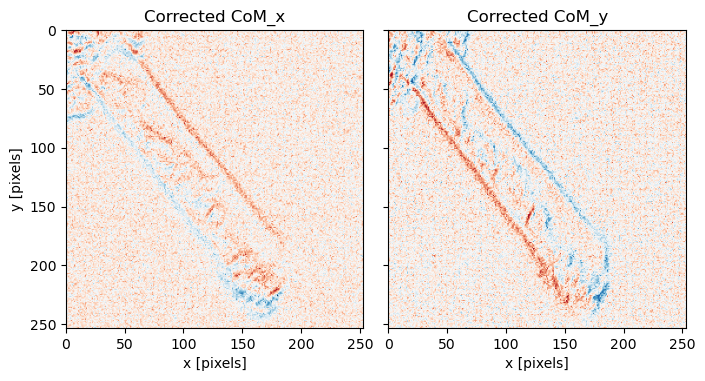

In [91]:
dpc_180 = py4DSTEM.process.phase.DPCReconstruction(
    dataset,
    energy=80e3,
).preprocess(
    force_com_rotation = np.rad2deg(dpc._rotation_best_rad) + 180.0,
    force_com_transpose = False,
)

In [92]:
dpc_180.reconstruct(
    max_iter=32
);

Reconstructing phase:  75%|██████████████████████████████████████████▊              | 24/32 [00:01<00:00, 19.43 iter/s]c:\users\cophus\repos\py4dstem\py4DSTEM\process\phase\iterative_dpc.py:384: UserWarning: Step-size has decreased below stopping criterion 1e-06.
  warnings.warn(
Reconstructing phase:  75%|██████████████████████████████████████████▊              | 24/32 [00:01<00:00, 18.71 iter/s]


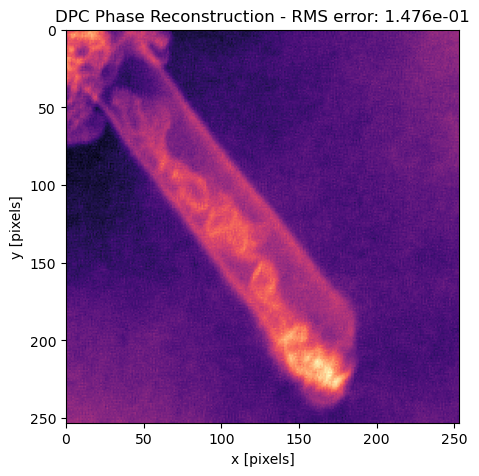

In [93]:
dpc_180.visualize(
    figsize=(6,6),
);

Looks very good!  Now the phase shift of the object is positive everywhere. The main remianing artifact is the slowly varying phase out in the vacuum - this is because DPC is not very accurate at recovering the lowest spatial frequencies, which correspond to the long period wavelengths which cover the field of view.

# Part 3 - Ptychographic Reconstruction <a class="anchor" id="part_03"></a>

DPC reduces each diffraction pattern to just 2 numbers: the average momentum in the x and y directions (the center of mass). Our measured diffraction patterns however contain a lot more information - enough information in fact to fully deconvolve the probe wavefunction from the object wave. In this section, we will perform a ptychographic reconstruction of the nanotube.

### Brief algorithm description

In py4DSTEM, we typically use parallel update gradient descent, with alternating iterative updates of the object wave and probe. We simulate the propagation of the probe through the object wave, and then calculate the error relative to the measured diffraction pattern intensities. This error is used to calculate a gradent update step for the object wave. A similar process is used to update the probe wave, and we alternate these updates until convergence.

The diffraction space sampling of this dataset is much higher than it needs to be - this experiment was performed with the probe nearly in focus. Therefore we will also bin the data significantly to speed up the reconstruction.

In [50]:
# First let's manually determine the pixel size in diffraction space.
# Above we estimated a probe semiangle of 19 pixels, and the HDF5 file
# says the probe is 26 mrads, for an accelerating voltage of 80 keV.
# At 80 keV, the wavelength is 0.04176 Angstroms.  We can therefore get q_probe as
q_probe = (26/1000) / 0.04176
# Now we can estimate the sampling using our semiangles in pixels:
k_sampling = q_probe / 19
# giving:
print('Diffraction space pixel size = ' + str(np.round(k_sampling,decimals=3)) + ' 1/A')

Diffraction space pixel size = 0.033 1/A


In [51]:
# # Next let's bin the data:
# bin_factor = 4

# dataset_bin = py4DSTEM.io.datastructure.DataCube(
#     data = f['4DSTEM_experiment']['data']['datacubes']['datacube_0']['datacube'][:]
# ).bin_Q(bin_factor)

In [69]:
# Next, we will bin and pad the data.  
# We can bin the data because the probe is close to zero defocus, and therefore has a small spatial extent.
# We can pad the data because the step size is smaller than the maximum real space sampling
# implied by k_max in diffraction space.
bin_factor = 6
pad_factor = 2

# bin data
dataset_bin = py4DSTEM.io.datastructure.DataCube(
    data = f['4DSTEM_experiment']['data']['datacubes']['datacube_0']['datacube'][:]
).bin_Q(bin_factor)

# pad data
pad_kx = np.round(dataset_bin.data.shape[2]*(pad_factor - 1)/2).astype('int')
pad_ky = np.round(dataset_bin.data.shape[3]*(pad_factor - 1)/2).astype('int')
pad_width = (
    (0,0),
    (0,0),
    (pad_kx,pad_kx),
    (pad_ky,pad_ky),
)
dataset_pad = py4DSTEM.io.datastructure.DataCube(
    data = np.pad(dataset_bin.data, pad_width = pad_width, mode='constant')
)

In [75]:
# We also need to specify both the step size and diffraction space sampling for ptychography:
# dataset_bin.calibration.set_Q_pixel_size(k_sampling * bin_factor)
# dataset_bin.calibration.set_Q_pixel_units('A^-1')
# dataset_bin.calibration.set_R_pixel_size(0.28)
# dataset_bin.calibration.set_R_pixel_units('A')
dataset_pad.calibration.set_Q_pixel_size(k_sampling * bin_factor)
dataset_pad.calibration.set_Q_pixel_units('A^-1')
dataset_pad.calibration.set_R_pixel_size(0.28)
dataset_pad.calibration.set_R_pixel_units('A')

c:\users\cophus\repos\py4dstem\py4DSTEM\process\phase\iterative_base_class.py:388: UserWarning: Best fit rotation forced to 168.0 degrees.
  Corrected vertical center of mass gradient, on calculation device
c:\users\cophus\repos\py4dstem\py4DSTEM\process\phase\iterative_base_class.py:402: UserWarning: Transpose of intensities forced to False.
  xp = self._xp


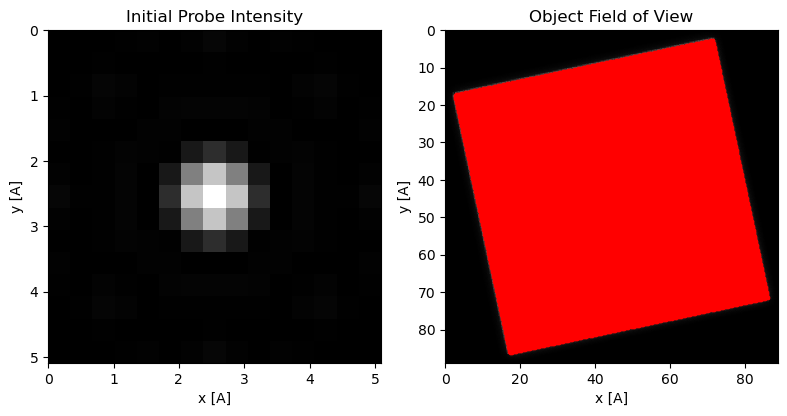

In [76]:
ptycho = py4DSTEM.process.phase.PtychographicReconstruction(
    dataset_pad,
    verbose=True,
    energy=80e3,
    semiangle_cutoff=26,
    defocus=0,
).preprocess(
    plot_center_of_mass = False,
    plot_rotation = False,
    force_com_rotation = np.rad2deg(dpc._rotation_best_rad) + 180.0,
    force_com_transpose = False,
    plot_probe_overlaps = True,
)

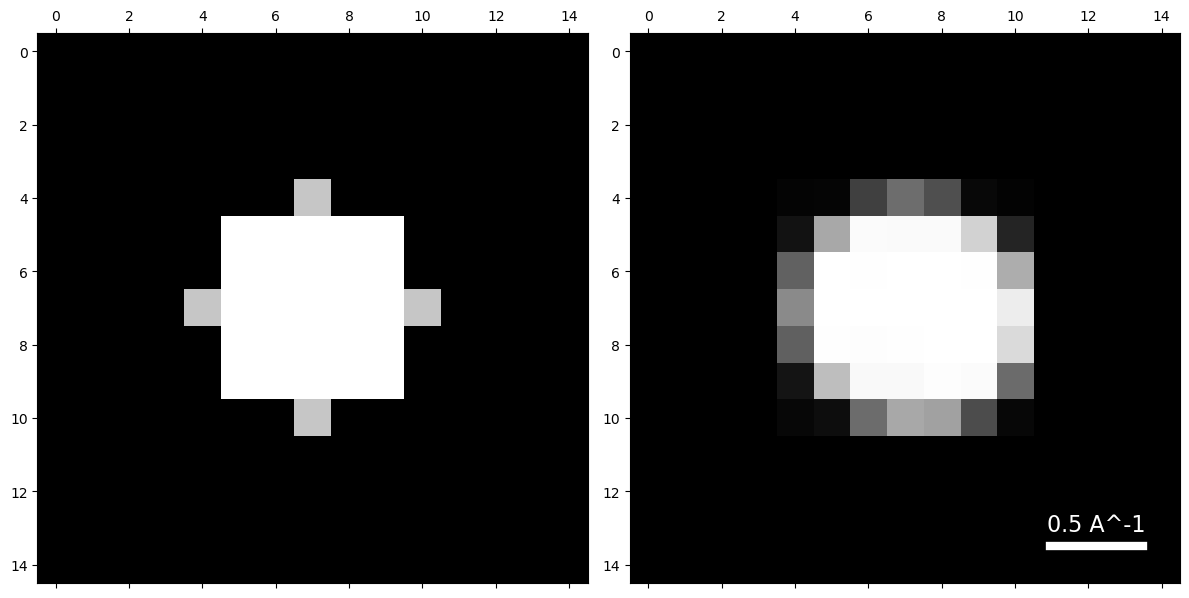

In [78]:
# Next lets check to make sure our probe semiangle is a good initial guess for the probe, 
# by comparing it to the experimental mean diffraction pattern:
py4DSTEM.show([
    np.fft.fftshift(np.abs(np.fft.fft2(ptycho._probe))),
    dataset_pad.get_dp_mean()
])

Reconstructing object and probe: 100%|██████████████████████████████████████████████| 16/16 [02:05<00:00,  7.84s/ iter]


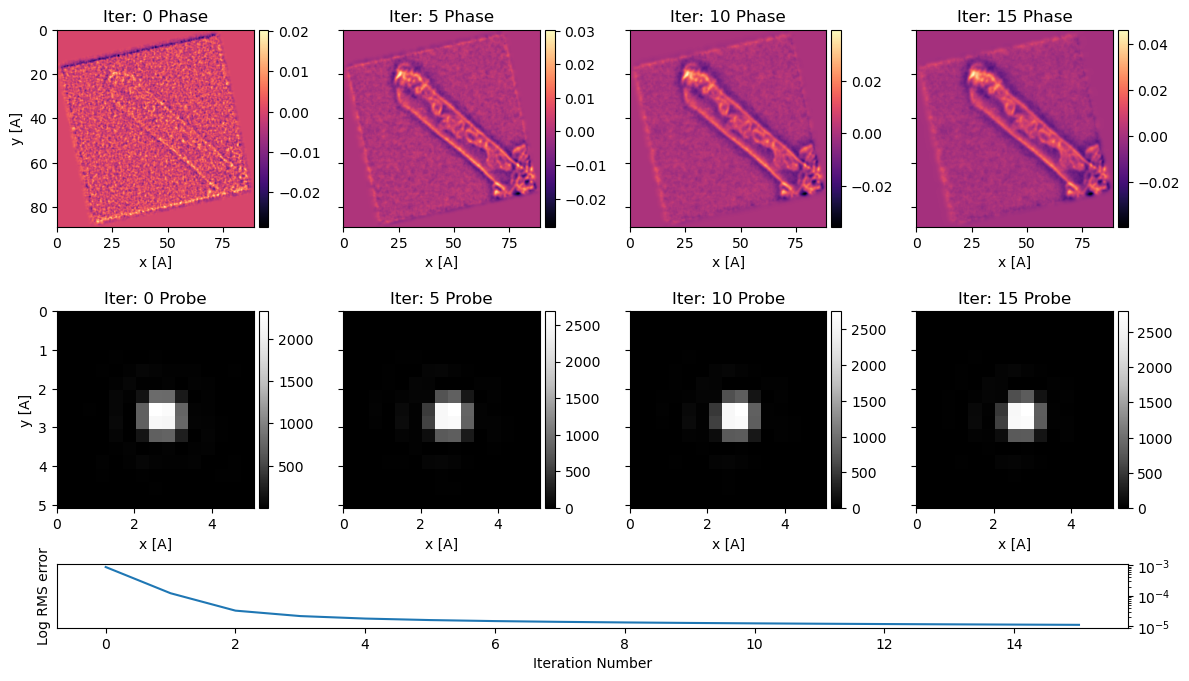

In [85]:
ptycho = ptycho.reconstruct(
    reset=True,
    progress_bar = True,
    store_iterations = True,
    max_iter = 16,
    fix_probe_iter = 0,
    pure_phase_object_iter = 4,
    step_size = 0.9,
    normalization_min = 0.2,
    gaussian_blur_sigma = 0.75,
).visualize(
    cbar=True,
    iterations_grid='auto',
    plot_convergence=True,
    plot_probe=True,
    object_mode='phase',
)

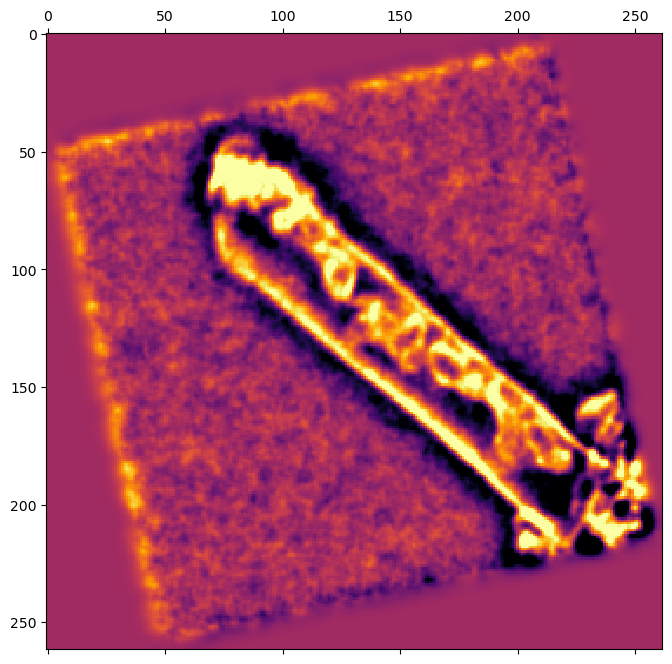

In [86]:
# Let's take a closer look at the phase reconstruction:
py4DSTEM.show(
    np.angle(ptycho.object),
    cmap='inferno',
)

# Part 4 - Comparing DPC to ptychography <a class="anchor" id="part_04"></a>

When the probe is very close to zero defocus, we would not expect to see much difference between DPC and ptychography. Ptychography may be a little bit sharper due to its ability to deconvolve the probe aberrations, but DPC can more easily recover lower spatial frequencies (though often with some artifacts!)  Here we will compare the two reconstructions.

Note that in DPC we rotated diffraction space, whereas in ptychography we rotate real space.  Therefore we need to rotate one of the results by about 180 degrees for a comparison.

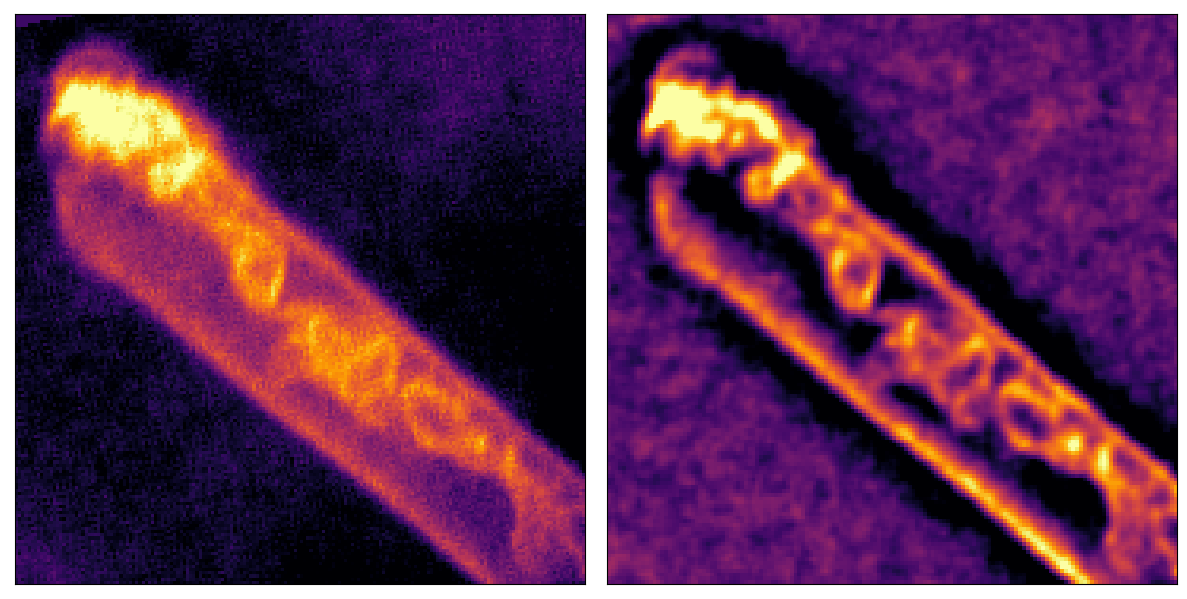

In [154]:
# comparison plot
dpc_crop = rotate(dpc_180.object_phase,192)[35:215,65:245]
ptycho_crop = np.angle(ptycho.object[35:185,60:210])

py4DSTEM.show([
    dpc_crop,
    ptycho_crop,
    ],
    cmap = 'inferno',
    ticks=False,
    vmin=0.1,
    vmax=0.99,
)

# left - DPC    right - ptychographic phase

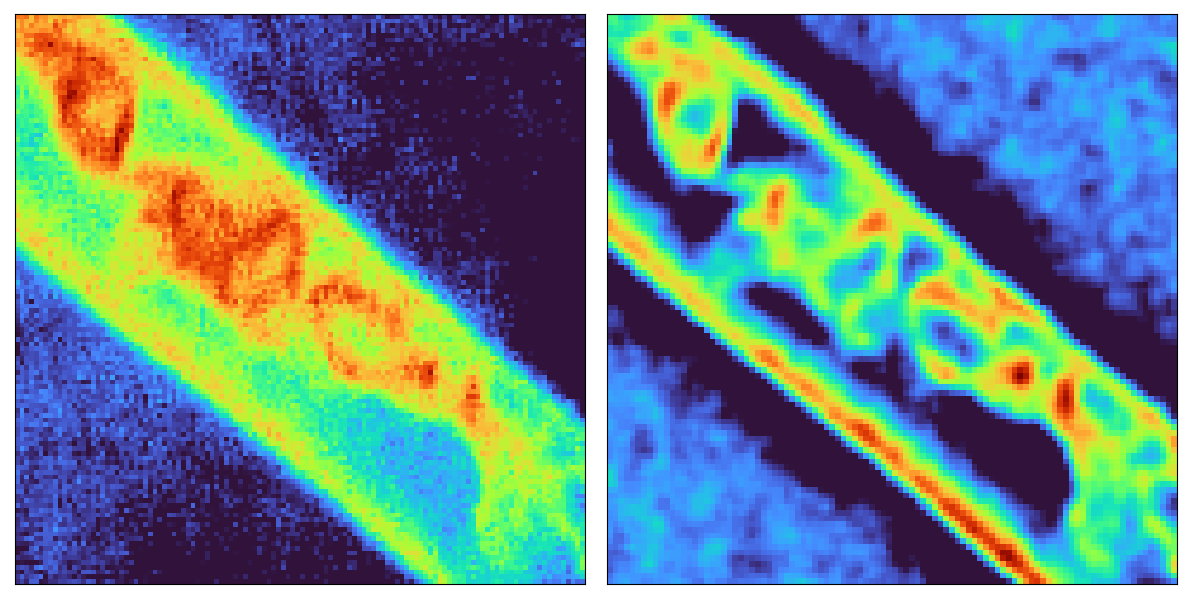

In [155]:
# another comparison plot
dpc_crop = rotate(dpc_180.object_phase,192)[95:215,125:245]
ptycho_crop = np.angle(ptycho.object[85:185,110:210])

py4DSTEM.show([
    dpc_crop,
    ptycho_crop,
    ],
    cmap = 'turbo',
    ticks=False,
    vmin=0.2,
    vmax=1,
)